In [ ]:
# !pip install keras-cv

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_cv

import matplotlib.pyplot as plt
import seaborn as sn

import numpy as np

keras.utils.set_random_seed(31)

### Dataset Preparation

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [4]:
num_samples = x_train.shape[0]
indices = np.arange(num_samples)
np.random.shuffle(indices)

x_train, y_train = x_train[indices], y_train[indices]

val_size = int(0.1 * num_samples)

x_val, y_val = x_train[:val_size], y_train[:val_size]
x_train, y_train = x_train[val_size:], y_train[val_size:]

print(f"Training set: {x_train.shape}, {y_train.shape}")
print(f"Validation set: {x_val.shape}, {y_val.shape}")
print(f"Test set: {x_test.shape}, {y_test.shape}")

Training set: (45000, 32, 32, 3), (45000, 1)
Validation set: (5000, 32, 32, 3), (5000, 1)
Test set: (10000, 32, 32, 3), (10000, 1)


In [5]:
def plot_sample(img):
  plt.figure(figsize=(10,1))
  plt.imshow(img)
  plt.plot()

Label is 5


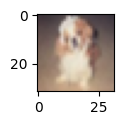

In [6]:
# sample image
plot_sample(x_train[0])
print("Label is", y_train[0][0])

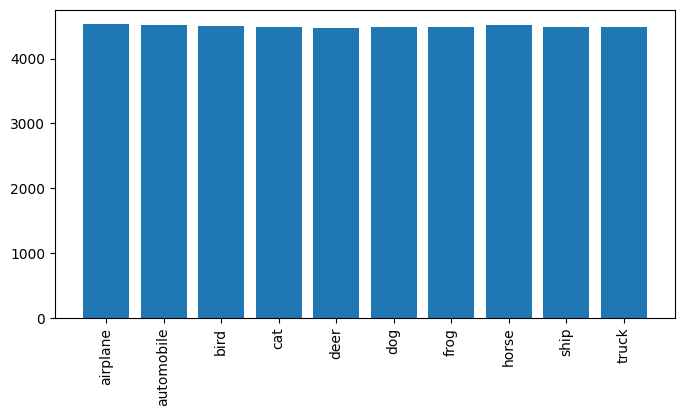

In [8]:
# class distribution
classes = ["airplane",
          "automobile",
          "bird",
          "cat",
          "deer",
          "dog",
          "frog",
          "horse",
          "ship",
          "truck"]

class_dist = {i:0 for i in classes}
for i in y_train:
  class_dist[classes[i[0]]] += 1

plt.figure(figsize=(8,4))
plt.bar(class_dist.keys(), class_dist.values())
plt.xticks(rotation=90)
plt.plot();

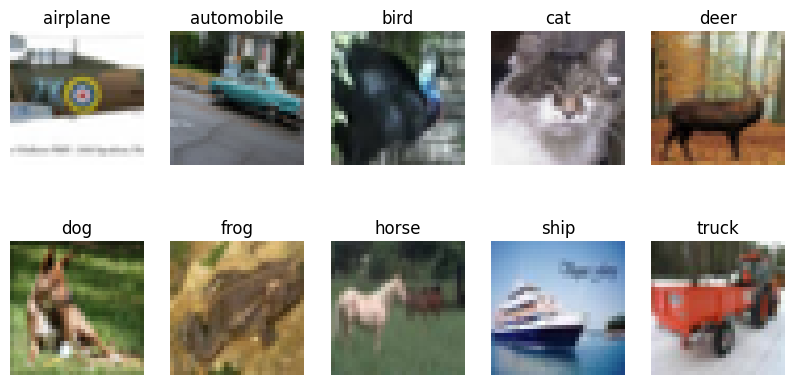

In [9]:
# samples from each class
samples = {i: None for i in classes}
for i in range(155, len(y_train)):
  if samples[classes[y_train[i][0]]] is None:
    samples[classes[y_train[i][0]]] = x_train[i]
  else:
    continue

plt.figure(figsize=(10,5))
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(samples[classes[i]])
  plt.title(classes[i])
  plt.axis("off")

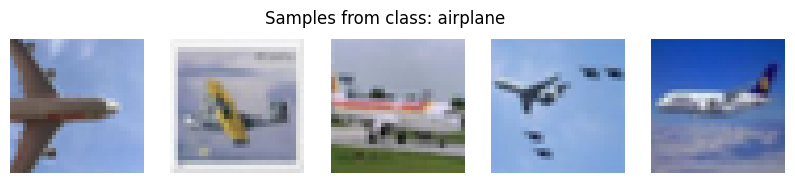

In [10]:
# different samples from one class
def plot_samples(class_name):
    samples = []
    for i in range(1231, len(y_train)):
        if len(samples) == 5:
            break
        if classes[y_train[i][0]] == class_name:
            samples.append(x_train[i])
    plt.figure(figsize=(10, 2))
    plt.suptitle(f'Samples from class: {class_name}', fontsize=12)
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(samples[i])
        plt.axis("off")

plot_samples("airplane")

#### Data Augmentation

In [31]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMAGE_SIZE = 32

In [32]:
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255), augmentations_per_image=3, magnitude=0.2
)

In [33]:
def prepare_image_dataset(dataset, shuffle=False, augment=False) -> tf.data.Dataset:
    if shuffle:
        dataset = dataset.shuffle(BATCH_SIZE * 1000)

    dataset = dataset.batch(BATCH_SIZE)

    dataset = dataset.map(
        lambda x, y: (tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)), y),
        num_parallel_calls=AUTO,
    )

    if augment:
        dataset = dataset.map(
            lambda x, y: (rand_augment(x), y),  # RandAugment can process it
            num_parallel_calls=AUTO,
        )

    dataset = dataset.map(
        lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
        num_parallel_calls=AUTO,
    )

    return dataset.prefetch(AUTO)

In [34]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_ds = prepare_image_dataset(train_ds, shuffle=True, augment=True)
val_ds = prepare_image_dataset(val_ds)
test_ds = prepare_image_dataset(test_ds)

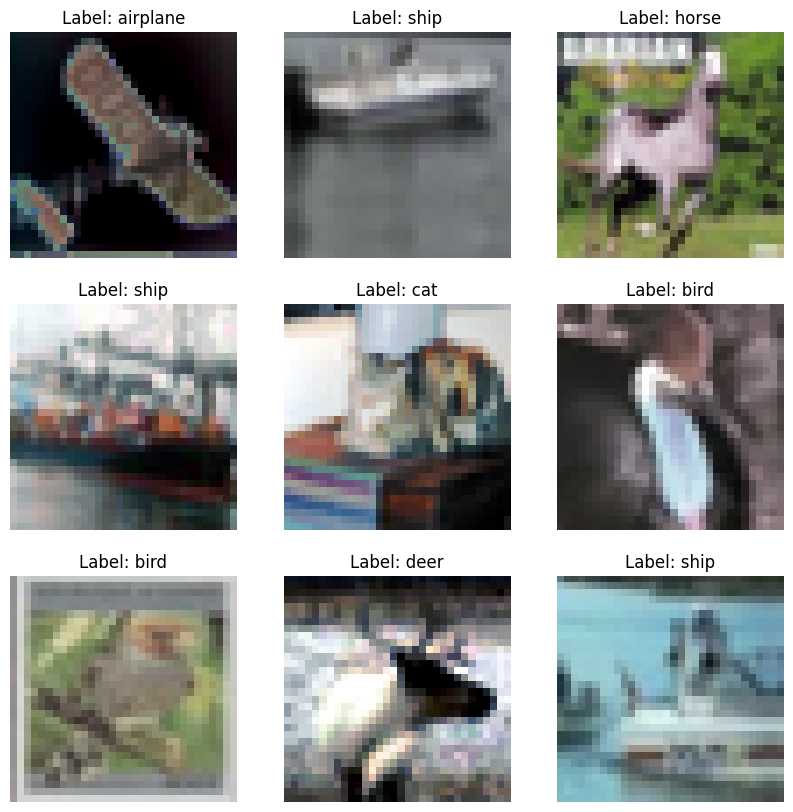

In [35]:
sample_images, labels = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy())
    plt.title(f"Label: {classes[int(labels[i])]}")
    plt.axis("off")

### Training

In [36]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        print('start with GPU 0')
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

start with GPU 0
Physical devices cannot be modified after being initialized


In [37]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [38]:
model = keras.Sequential([
    layers.Conv2D(filters=64, padding='same', kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(32,32,3)),
    layers.Conv2D(filters=64, padding='same', kernel_size=(3,3), strides=(1,1), activation='relu'),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(filters=128, padding='same', kernel_size=(3,3), strides=(1,1), activation='relu'),
    layers.Conv2D(filters=128, padding='same', kernel_size=(3,3), strides=(1,1), activation='relu'),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(filters=256, padding='same', kernel_size=(3,3), strides=(1,1), activation='relu'),
    layers.Conv2D(filters=256, padding='same', kernel_size=(3,3), strides=(1,1), activation='relu'),
    layers.Conv2D(filters=256, padding='same', kernel_size=(3,3), strides=(1,1), activation='relu'),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(filters=512, padding='same', kernel_size=(3,3), strides=(1,1), activation='relu'),
    layers.Conv2D(filters=512, padding='same', kernel_size=(3,3), strides=(1,1), activation='relu'),
    layers.Conv2D(filters=512, padding='same', kernel_size=(3,3), strides=(1,1), activation='relu'),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(filters=512, padding='same', kernel_size=(3,3), strides=(1,1), activation='relu'),
    layers.Conv2D(filters=512, padding='same', kernel_size=(3,3), strides=(1,1), activation='relu'),
    layers.Conv2D(filters=512, padding='same', kernel_size=(3,3), strides=(1,1), activation='relu'),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

In [39]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)                   │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 2, 2, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 33,644,106 (128.34 MB)

 Trainable params: 33,641,162 (128.33 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [40]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [41]:
EPOCHS = 50

history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 75s 43ms/step - accuracy: 0.1463 - loss: 2.5055 - val_accuracy: 0.1870 - val_loss: 1.9991
Epoch 2/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 57s 39ms/step - accuracy: 0.1857 - loss: 2.0556 - val_accuracy: 0.2556 - val_loss: 1.9372
Epoch 3/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 56s 39ms/step - accuracy: 0.2010 - loss: 1.9923 - val_accuracy: 0.2078 - val_loss: 1.8933
Epoch 4/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 56s 39ms/step - accuracy: 0.2254 - loss: 1.9140 - val_accuracy: 0.2960 - val_loss: 1.7192
Epoch 5/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 57s 39ms/step - accuracy: 0.3157 - loss: 1.7275 - val_accuracy: 0.4544 - val_loss: 1.4124
Epoch 6/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 57s 39ms/step - accuracy: 0.4010 - loss: 1.5817 - val_accuracy: 0.4646 - val_loss: 1.3996
Epoch 7/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 57s 39ms/step - accuracy: 0.4591 - loss: 1.4708 - val_accuracy: 0.4436 - val_loss: 1.4601
Epoch 8/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 57s 39ms/step - accuracy: 0.5024 -

### Evaluation

In [42]:
train_ds_original = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds_original = prepare_image_dataset(train_ds_original)

In [43]:
_, acc = model.evaluate(train_ds_original)
print("Training Accuracy = ", (acc * 100.0), "%")

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9539 - loss: 73.0197
Training Accuracy =  95.29777765274048 %


In [44]:
_, acc = model.evaluate(test_ds)
print("Test Accuracy = ", (acc * 100.0), "%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8706 - loss: 175.1111
Test Accuracy =  86.58999800682068 %


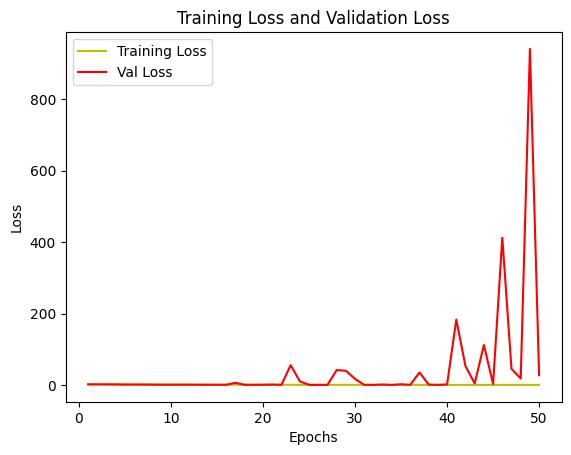

In [45]:
# plot the loss curve
loss_curve = history.history["loss"]
val_loss_curve = history.history["val_loss"]
epochs = range(1, len(loss_curve) + 1)
plt.plot(epochs, loss_curve, 'y', label="Training Loss")
plt.plot(epochs, val_loss_curve, 'r', label="Val Loss")
plt.title("Training Loss and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

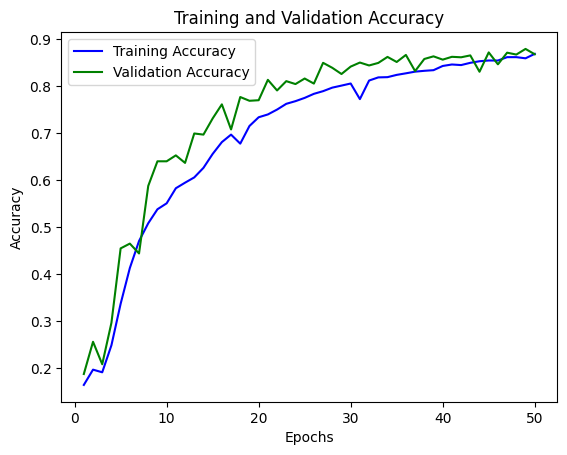

In [46]:
# plot the accuracy curve
acc_curve = history.history["accuracy"]
val_acc_curve = history.history["val_accuracy"]
epochs = range(1, len(acc_curve) + 1)
plt.plot(epochs, acc_curve, 'b', label="Training Accuracy")
plt.plot(epochs, val_acc_curve, 'g', label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [47]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_ds)
y_pred_classes = [np.argmax(element) for element in y_pred]

print(classification_report(y_test, y_pred_classes))

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      1000
           1       0.95      0.95      0.95      1000
           2       0.83      0.80      0.82      1000
           3       0.76      0.73      0.74      1000
           4       0.80      0.92      0.86      1000
           5       0.89      0.69      0.78      1000
           6       0.83      0.94      0.88      1000
           7       0.86      0.94      0.90      1000
           8       0.98      0.85      0.91      1000
           9       0.93      0.94      0.93      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.86     10000
weighted avg       0.87      0.87      0.86     10000



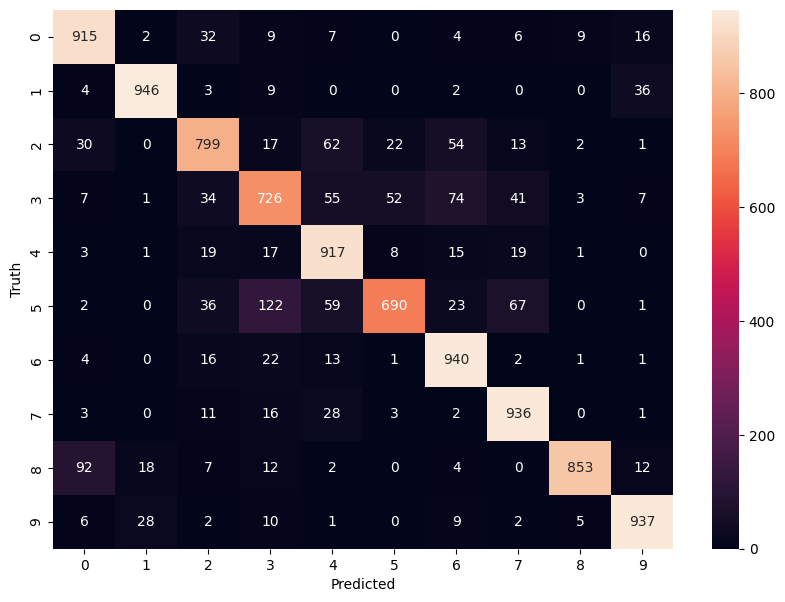

In [48]:
cm = tf.math.confusion_matrix(y_test, np.argmax(y_pred, axis=1))

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### **Comparison of AlexNet and VGG Performance**

In this experiment, we compared the performance of **AlexNet** and **VGG** on CIFAR-10 dataset. The key metrics evaluated were **training accuracy, test accuracy, and the number of parameters** in each model. Data Augmentation is used in the training of both models.

#### **Results**

| Model  | Training Accuracy (%) | Test Accuracy (%) | Parameters (Millions) | Epochs |
|--------|----------------------|-------------------|----------------------|--------|
| **AlexNet** | 81.97 | 77.53 | 3.2M | 50 |
| **VGG + BatchNorm** | 95.29 | 86.58 | 33.6M | 50 |

#### **Analysis**
1. **Accuracy**:  
   - VGG outperformed AlexNet in both training and test accuracy.  
   - The test accuracy improved from **77.53% (AlexNet) to 86.58% (VGG)**, suggesting that VGG captures more complex patterns in the data.

2. **Overfitting**:  
   - VGG has a larger gap between training and test accuracy (**95.29% vs. 86.58%**), which indicates **higher overfitting** compared to AlexNet (**81.97% vs. 77.53%**).
   - Although various techniques applied to prevent overfitting (data augmentation, dropout), interestingly the model has high overfitting. It could be the case because this is an unnecessarily big model for the task.

3. **Model Complexity**:  
   - VGG has significantly more parameters (**33.6M vs. 3.2M in AlexNet**), making it **computationally expensive** and requiring more memory.
   - The higher number of parameters in VGG contributes to its better accuracy but also increases the risk of overfitting.

#### **Conclusion**
- **VGG achieves better performance** but at the cost of **higher computational complexity** and **increased overfitting**.  
- **AlexNet is more lightweight** and generalizes reasonably well with significantly fewer parameters.  
- Choosing between the two depends on the available **hardware resources** and the **need for accuracy vs. efficiency**.